## Parse the data

In [17]:
root = 'KMRLOpenData'

In [18]:
import os
os.listdir(root)


['stops.txt',
 'shapes.txt',
 'translations.txt',
 'trips.txt',
 'fare_rules.txt',
 'stop_times.txt',
 'feed_info.txt',
 'fare_attributes.txt',
 'calendar.txt',
 'routes.txt',
 'agency.txt']

In [19]:
import pandas as pd
df=pd.read_csv(root+'/stops.txt')
display(df.head(5))

,stop_id,stop_lat,stop_lon,stop_name,stop_desc,location_type,zone_id,wheelchair_boarding
0,ALVA,10.1099,76.3495,Aluva,NaN,0,ALVA,1
1,PNCU,10.0951,76.3466,Pulinchodu,NaN,0,PNCU,1
2,CPPY,10.0873,76.3428,Companypady,NaN,0,CPPY,1
3,ATTK,10.0793,76.3389,Ambattukavu,NaN,0,ATTK,1
4,MUTT,10.0727,76.3336,Muttom,NaN,0,MUTT,1


## Create the geometry layer

In [20]:
from shapely.geometry import Point

In [21]:
import geopandas as gpd

In [22]:
geometry= [Point(xy) for xy in zip (df['stop_lon'], df['stop_lat'])]
geometry[0:5]

[<POINT (76.35 10.11)>,
 <POINT (76.347 10.095)>,
 <POINT (76.343 10.087)>,
 <POINT (76.339 10.079)>,
 <POINT (76.334 10.073)>]

In [23]:
gdf=df.copy()
gdf['geometry']=geometry
type(gdf)

pandas.core.frame.DataFrame

In [24]:
gdf=gpd.GeoDataFrame(gdf)
type(gdf)

geopandas.geodataframe.GeoDataFrame

In [25]:
gdf.head(5)

,stop_id,stop_lat,stop_lon,stop_name,stop_desc,location_type,zone_id,wheelchair_boarding,geometry
0,ALVA,10.1099,76.3495,Aluva,NaN,0,ALVA,1,POINT (76.3495 10.1099)
1,PNCU,10.0951,76.3466,Pulinchodu,NaN,0,PNCU,1,POINT (76.3466 10.0951)
2,CPPY,10.0873,76.3428,Companypady,NaN,0,CPPY,1,POINT (76.3428 10.0873)
3,ATTK,10.0793,76.3389,Ambattukavu,NaN,0,ATTK,1,POINT (76.3389 10.0793)
4,MUTT,10.0727,76.3336,Muttom,NaN,0,MUTT,1,POINT (76.3336 10.0727)


<Axes: >

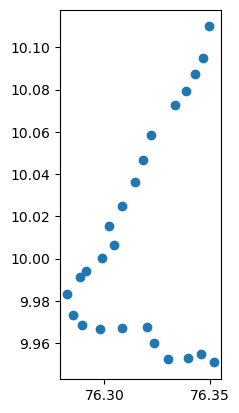

In [26]:
gdf.plot()

(np.float64(76.2788235),
 np.float64(76.35530650000001),
 np.float64(9.942824),
 np.float64(10.117856))

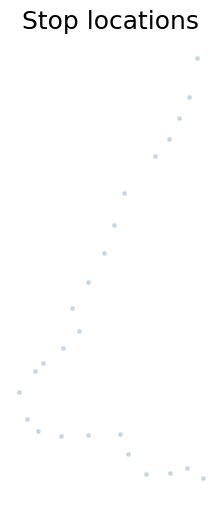

In [27]:
import matplotlib.pyplot as plt
f,ax=plt.subplots(1,1, figsize=(6,6))
ax.set_title('Stop locations',fontsize=18)
gdf.plot(ax=ax, alpha=0.2, markersize=6)
ax.axis('off')

In [28]:
# ============================================================
# STEP 1: Load GTFS Data & Explore
# Kochi Metro (KMRL) Last-Mile & Service Risk Analysis
# ============================================================

import pandas as pd
import os

root = 'KMRLOpenData'

# --- Load all relevant GTFS files ---
stops      = pd.read_csv(f'{root}/stops.txt')
routes     = pd.read_csv(f'{root}/routes.txt')
trips      = pd.read_csv(f'{root}/trips.txt')
stop_times = pd.read_csv(f'{root}/stop_times.txt')
calendar   = pd.read_csv(f'{root}/calendar.txt')

print("=== STOPS ===")
print(stops.shape)
display(stops.head(3))

print("\n=== ROUTES ===")
print(routes.shape)
display(routes.head(3))

print("\n=== TRIPS ===")
print(trips.shape)
display(trips.head(3))

print("\n=== STOP_TIMES ===")
print(stop_times.shape)
display(stop_times.head(3))

print("\n=== CALENDAR ===")
display(calendar)

=== STOPS ===
(25, 8)


,stop_id,stop_lat,stop_lon,stop_name,stop_desc,location_type,zone_id,wheelchair_boarding
0,ALVA,10.1099,76.3495,Aluva,NaN,0,ALVA,1
1,PNCU,10.0951,76.3466,Pulinchodu,NaN,0,PNCU,1
2,CPPY,10.0873,76.3428,Companypady,NaN,0,CPPY,1



=== ROUTES ===
(1, 5)


,route_id,route_short_name,route_long_name,route_type,agency_id
0,R1,KMRL,Kochi Metro Route 1,1,KMRL



=== TRIPS ===
(450, 5)


,route_id,service_id,trip_id,direction_id,shape_id
0,R1,WK,WK_1,0,R1_0
1,R1,WK,WK_2,1,R1_1
2,R1,WK,WK_22,0,R1_0



=== STOP_TIMES ===
(10726, 7)


,trip_id,stop_sequence,stop_id,arrival_time,departure_time,timepoint,shape_dist_traveled
0,WE_1,1,TPHT,22:50:19,22:52:41,1,0.00
1,WE_1,2,SNJN,22:54:30,22:54:45,1,0.99
2,WE_1,3,VAKK,22:56:08,22:56:23,1,1.72



=== CALENDAR ===


,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,WK,1,1,1,1,1,1,0,20240812,20251231
1,WE,0,0,0,0,0,0,1,20240812,20251231


In [33]:
# ============================================================
# STEP 2 (revised): Headway Analysis & Passenger Wait Risk
# ============================================================

import geopandas as gpd
from shapely.geometry import Point
import numpy as np

# --- Service hours assumption: KMRL runs ~18 hrs/day (6am-midnight) ---
SERVICE_HOURS = 18
SERVICE_MINUTES = SERVICE_HOURS * 60  # 1080 minutes

# --- Count weekday trips per stop ---
weekday_trips = trips[trips['service_id'] == 'WK']['trip_id']
weekday_stop_times = stop_times[stop_times['trip_id'].isin(weekday_trips)]

trips_per_stop = (
    weekday_stop_times
    .groupby('stop_id')['trip_id']
    .nunique()
    .reset_index()
    .rename(columns={'trip_id': 'weekday_trips'})
)

# --- Calculate average headway (minutes between trains) ---
# Each stop serves both directions, so divide trips by 2 for one direction
trips_per_stop['one_direction_trips'] = trips_per_stop['weekday_trips'] // 2
trips_per_stop['avg_headway_min'] = (SERVICE_MINUTES / trips_per_stop['one_direction_trips']).round(1)

# --- Merge with stop metadata ---
stops_freq = stops.merge(trips_per_stop, on='stop_id', how='left')

# --- Risk: headway > 8 min = poor frequency by urban transit standards ---
def classify_risk(h):
    if h > 10:
        return 'High Risk'
    elif h > 7:
        return 'Medium Risk'
    else:
        return 'Low Risk'

stops_freq['risk'] = stops_freq['avg_headway_min'].apply(classify_risk)

print("Headway stats:")
display(stops_freq[['stop_name', 'weekday_trips', 'one_direction_trips', 'avg_headway_min', 'risk']]
        .sort_values('avg_headway_min', ascending=False))

print("\nRisk distribution:")
print(stops_freq['risk'].value_counts())

Headway stats:


,stop_name,weekday_trips,one_direction_trips,avg_headway_min,risk
21,Pettah,240,120,9.0,Medium Risk
23,SN Junction,240,120,9.0,Medium Risk
18,Elamkulam,240,120,9.0,Medium Risk
20,Thykoodam,240,120,9.0,Medium Risk
19,Vyttila,240,120,9.0,Medium Risk
24,Tripunithura,240,120,9.0,Medium Risk
22,Vadakkekotta,240,120,9.0,Medium Risk
6,Cochin University,242,121,8.9,Medium Risk
8,Edapally,242,121,8.9,Medium Risk
16,Ernakulam South,242,121,8.9,Medium Risk



Risk distribution:
risk
Medium Risk    25
Name: count, dtype: int64


In [40]:
# --- GeoDataFrame ---
geometry = [Point(lon, lat) for lon, lat in zip(stops_freq['stop_lon'], stops_freq['stop_lat'])]
gdf = gpd.GeoDataFrame(stops_freq, geometry=geometry, crs='EPSG:4326')
print("\nGeoDataFrame ready with", len(gdf), "stops")
print(gdf[['stop_name', 'weekday_trips', 'risk', 'geometry']].head())


GeoDataFrame ready with 25 stops
     stop_name  weekday_trips         risk                 geometry
0        Aluva            246  Medium Risk  POINT (76.3495 10.1099)
1   Pulinchodu            246  Medium Risk  POINT (76.3466 10.0951)
2  Companypady            246  Medium Risk  POINT (76.3428 10.0873)
3  Ambattukavu            246  Medium Risk  POINT (76.3389 10.0793)
4       Muttom            255  Medium Risk  POINT (76.3336 10.0727)


In [42]:
# ============================================================
# STEP 3: Interactive Folium Map
# ============================================================

import folium

# --- Color mapping ---
risk_colors = {
    'High Risk':   'red',
    'Medium Risk': 'orange',
    'Low Risk':    'green'
}

# --- Base map centered on Kochi ---
m = folium.Map(
    location=[10.02, 76.31],
    zoom_start=12,
    tiles='CartoDB positron'
)

# --- Add each metro stop as a circle marker ---
for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=10,
        color=risk_colors[row['risk']],
        fill=True,
        fill_color=risk_colors[row['risk']],
        fill_opacity=0.8,
        popup=folium.Popup(
            f"""
            <b>{row['stop_name']}</b><br>
            Weekday Trips: {row['weekday_trips']}<br>
            Trips (one direction): {row['one_direction_trips']}<br>
            Avg Headway: {row['avg_headway_min']} min<br>
            Risk Level: {row['risk']}
            """,
            max_width=200
        ),
        tooltip=f"{row['stop_name']} — {row['avg_headway_min']} min headway"
    ).add_to(m)

# --- Draw the metro line (connect stops in sequence order) ---
line_coords = stops_freq.sort_values('stop_id')[['stop_lat', 'stop_lon']].values.tolist()
folium.PolyLine(
    locations=line_coords,
    color='blue',
    weight=3,
    opacity=0.5,
    tooltip='KMRL Metro Line'
).add_to(m)

# --- Legend (manual HTML) ---
legend_html = """
<div style="position: fixed; bottom: 40px; left: 40px; z-index: 1000;
     background-color: white; padding: 12px 16px; border-radius: 8px;
     border: 1px solid #ccc; font-family: Arial; font-size: 13px;">
  <b>Headway Risk Level</b><br>
  <i style="background:red;width:12px;height:12px;display:inline-block;border-radius:50%;margin-right:6px;"></i> High Risk (&gt;10 min)<br>
  <i style="background:orange;width:12px;height:12px;display:inline-block;border-radius:50%;margin-right:6px;"></i> Medium Risk (7–10 min)<br>
  <i style="background:green;width:12px;height:12px;display:inline-block;border-radius:50%;margin-right:6px;"></i> Low Risk (&lt;7 min)<br>
  <br>
  <small>Source: KMRL Open GTFS Data</small>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# --- Save ---
import os
os.makedirs('output', exist_ok=True)
m.save('output/kochi_metro_headway_map.html')

print("Map saved to output/kochi_metro_headway_map.html")
m  # display inline in notebook


Map saved to output/kochi_metro_headway_map.html
